## **Clasificador para un dataset en forma anillada**

**1. Importamos las librerías necesarias**

In [1]:
# generales:
import os
import numpy as np
import pandas as pd
import tensorflow as tf

# para las redes neuronales:
from keras import models, layers
from keras.optimizers import SGD
from keras.utils.vis_utils import plot_model

# para plotting:
from matplotlib import cm
from matplotlib import pyplot as plt
%matplotlib inline

f"tensorflow version: {tf.__version__}"

'tensorflow version: 2.9.2'

**2. Creamos los tensores para los datos de entrada y los _targets_**

In [6]:
import random
import math

def getRingedData(radius=5, bound=7.5, xCenter=5, yCenter=5, A=75, B=250, show=False):
  x1, y1 = [], []
  x2, y2 = [], []

  for _ in range(A):
    alpha = 2 * math.pi * random.random()
    r = radius
    x1.append(r * math.cos(alpha) + xCenter)
    y1.append(r * math.sin(alpha) + yCenter)

  iter = 0
  while iter < B:
    alpha = 2 * math.pi * random.random()
    r = 2*radius * math.sqrt(random.random())
    if r > bound:
      x2.append(r * math.cos(alpha) + xCenter)
      y2.append(r * math.sin(alpha) + yCenter)
      iter += 1

  if show:
    plt.scatter(x1, y1, marker='^', color='green', label='positive')
    plt.scatter(x2, y2, marker='o', color='blue', label='negative')
    plt.legend(loc='lower right')
    plt.show()

  inner = [[x, y] for x, y in zip(x1, y1)] 
  outer = [[x, y] for x, y in zip(x2, y2)]

  x = x = np.array(inner + outer, 'float32')
  t = np.concatenate((np.ones(len(inner)), np.zeros(len(outer))), axis=0)
  return x, np.expand_dims(t, axis=1)

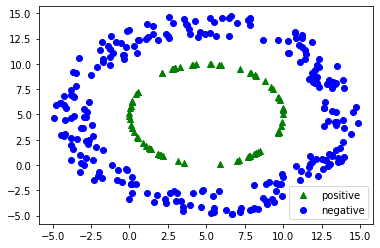

((325, 2), (325, 1))

In [7]:
X, y = getRingedData(show=True)
X.shape, y.shape

In [9]:
def getNetParams(x, t):
  if x.shape[0] != t.shape[0]:
    return 0, 0, 0
  features   = x.shape[1]
  categories = t.shape[1]
  samples    = x.shape[0]
  return features, categories, samples

In [10]:
features, categories, samples = getNetParams(X, y)
features, categories, samples

(2, 1, 325)

## **Modelo de la red**

In [18]:
def MLP(name, hiddenUnits=2):
    # crear el modelo
    model = models.Sequential(name=name)
    # capa oculta
    model.add(
        layers.Dense(
          name='hidden_layer',
          units=hiddenUnits,
          activation="sigmoid",
          input_dim=features # capa implicita de entrada
        )
    )
    # capa de salida
    model.add(
        layers.Dense(
            name='output_layer',
            units=categories,
        )
    )
    # compilar el modelo
    model.compile(loss='mean_squared_error', # función de pérdida
                  optimizer=SGD(learning_rate=0.1), # optimizador
                  metrics=["accuracy"]) # métricas con las que se evaluará el modelo
    return model

**4. Instanciamos y entrenamos nuestro modelo**

In [19]:
mlp = MLP(name="ring", hiddenUnits=3)
mlp.summary()

Model: "ring"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer (Dense)        (None, 3)                 9         
                                                                 
 output_layer (Dense)        (None, 1)                 4         
                                                                 
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


In [20]:
metrics = mlp.fit(X, y, epochs=2500, verbose=0)

### **Interpretando resultados**

**7. Observamos la función de pérdida de nuestro modelo durante el entrenamiento**

'min val: 0.020891331136226654, last val: 0.025497186928987503'

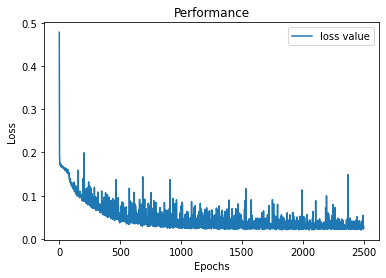

In [21]:
loss = metrics.history['loss']

ax = pd.DataFrame({'loss value': loss}).plot(title='Performance')
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.plot()

f"min val: {min(loss)}, last val: {loss[-1]}"

**6. Observamos los valores de los pesos**

In [22]:
W0 = mlp.layers[0].get_weights()[0]
b0 = mlp.layers[0].get_weights()[1]
W1 = mlp.layers[1].get_weights()[0]
b1 = mlp.layers[1].get_weights()[1]
W0, b0, W1, b1

(array([[-0.02854173,  0.6901403 , -0.6755279 ],
        [ 0.8182931 , -0.42703387, -0.39879823]], dtype=float32),
 array([-0.4153335,  2.2663248,  8.959618 ], dtype=float32),
 array([[1.7173591],
        [1.7068574],
        [1.7116185]], dtype=float32),
 array([-3.466133], dtype=float32))

**8. Observamos en un espacio tridimensional los datos de entrada y el hyperplano de separación**

In [25]:
def sigmoid(X):
   return 1/(1 + np.exp(-X)) 

In [35]:
t = np.arange(-12, 23, 1, dtype=int)
x1, x2 = np.meshgrid(t, t)

z1 = sigmoid(W0[0, 0]*x1 + W0[1, 0]*x2 + b0[0])
z2 = sigmoid(W0[0, 1]*x1 + W0[1, 1]*x2 + b0[1])
z3 = sigmoid(W0[0, 2]*x1 + W0[1, 2]*x2 + b0[2])
z  = sigmoid(W1[0]*z1 + W1[1]*z2 + W1[2]*z3 + b1[0])

3888/3888 [==============================] - 3s 850us/step


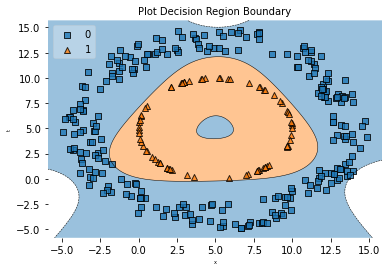

In [24]:
from mlxtend.plotting import plot_decision_regions

plot_decision_regions(X=X, y=y.reshape((-1,)).astype(int), clf=mlp, legend=2)
plt.xlabel("x", size=5)
plt.ylabel("t", size=5)
plt.title('Plot Decision Region Boundary', size=10)
plt.show()

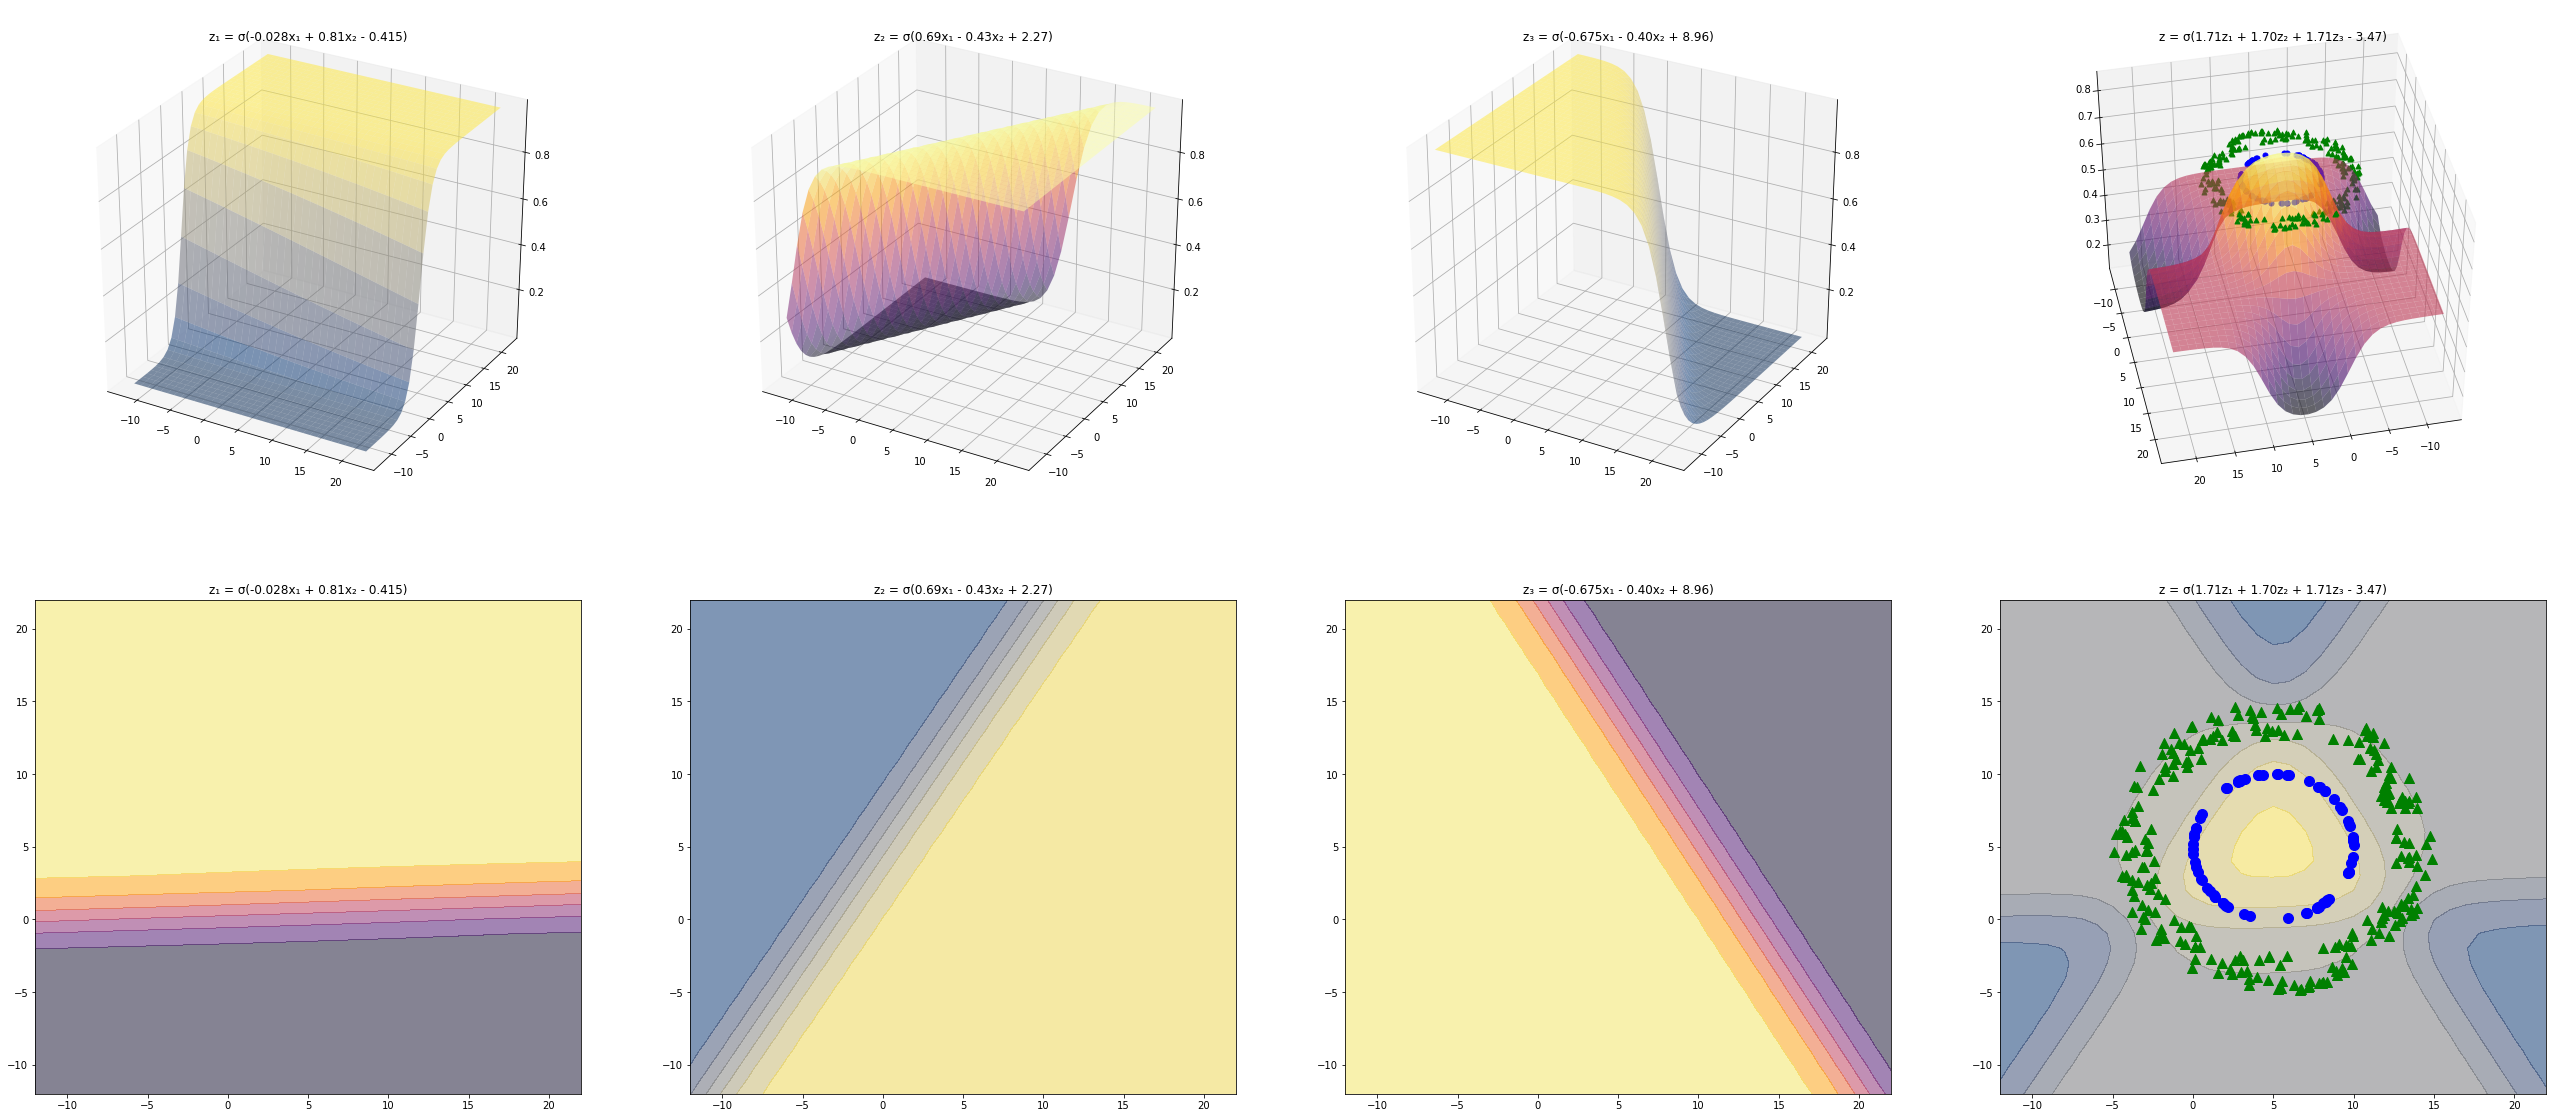

In [40]:
def plotBoundaries():
  fig = plt.figure(figsize=(45, 20))

  ax1 = plt.subplot(241, projection='3d')
  ax2 = plt.subplot(242, projection='3d')
  ax3 = plt.subplot(243, projection='3d')
  ax4 = plt.subplot(244, projection='3d')
  ax5 = plt.subplot(245)
  ax6 = plt.subplot(246)
  ax8 = plt.subplot(248)
  ax7 = plt.subplot(247)
  
  ax4.view_init(45, 78)
  ax1.set_title("z₁ = σ(-0.028x₁ + 0.81x₂ - 0.415)")
  ax2.set_title("z₂ = σ(0.69x₁ - 0.43x₂ + 2.27)")
  ax3.set_title("z₃ = σ(-0.675x₁ - 0.40x₂ + 8.96)")
  ax4.set_title("z = σ(1.71z₁ + 1.70z₂ + 1.71z₃ - 3.47)")

  ax5.set_title("z₁ = σ(-0.028x₁ + 0.81x₂ - 0.415)")
  ax6.set_title("z₂ = σ(0.69x₁ - 0.43x₂ + 2.27)")
  ax7.set_title("z₃ = σ(-0.675x₁ - 0.40x₂ + 8.96)")
  ax8.set_title("z = σ(1.71z₁ + 1.70z₂ + 1.71z₃ - 3.47)")

  ax1.plot_surface(x1, x2, z1, alpha=0.50, cmap=cm.cividis)
  ax2.plot_surface(x1, x2, z2, alpha=0.50, cmap=cm.inferno) 
  ax3.plot_surface(x1, x2, z3, alpha=0.50, cmap=cm.cividis)
  ax4.plot_surface(x1, x2,  z, alpha=0.60, cmap=cm.inferno)
  ax5.contourf(x1, x2, z1, alpha=0.50, cmap=cm.inferno)
  ax6.contourf(x1, x2, z2, alpha=0.50, cmap=cm.cividis)
  ax7.contourf(x1, x2, z3, alpha=0.50, cmap=cm.inferno)
  ax8.contourf(x1, x2,  z, alpha=0.50, cmap=cm.cividis)

  for u, v in zip(X.tolist(), y.tolist()):
    ax4.scatter(u[0], u[1], [0.75], s=25.0, c="green" if v[0] == 0 else "blue", marker="^" if v[0] == 0 else "o")
    ax8.scatter(u[0], u[1], s=100.0, c="green" if v[0] == 0 else "blue", marker="^" if v[0] == 0 else "o")
  plt.show()

plotBoundaries()